In [16]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import integrate, optimize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
# data preprocessing
data = pd.read_csv('owid-covid-data.csv')
country = 'Italy'
country_data = data[data.location == country]
country_data = country_data[country_data['total_cases'] > 0]
country_data

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
7631,ITA,Italy,2020-01-31,3,3,0,0,0.050,0.050,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7632,ITA,Italy,2020-02-01,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7633,ITA,Italy,2020-02-02,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7634,ITA,Italy,2020-02-03,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7635,ITA,Italy,2020-02-04,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725,ITA,Italy,2020-05-04,210717,1389,28884,174,3485.125,22.973,477.723,2.878,2191403.0,37631.0,36.244,0.622,tests performed
7726,ITA,Italy,2020-05-05,211938,1221,29079,195,3505.319,20.195,480.948,3.225,2246666.0,55263.0,37.158,0.914,tests performed
7727,ITA,Italy,2020-05-06,213013,1075,29315,236,3523.099,17.780,484.851,3.903,2310929.0,64263.0,38.221,1.063,tests performed
7728,ITA,Italy,2020-05-07,214457,1444,29684,369,3546.982,23.883,490.954,6.103,NaN,NaN,NaN,NaN,NaN


In [18]:
# split data according to selected date
# delay 6 days in the second phase
# country_data1 = country_data[(country_data['date'] >= '2020-01-31') & (country_data['date'] <= '2020-03-16')]
# country_data2 = country_data[country_data['date'] > '2020-03-16']

# no delay
country_data1 = country_data[(country_data['date'] >= '2020-01-31') & (country_data['date'] <= '2020-03-10')]
country_data2 = country_data[country_data['date'] > '2020-03-10']

# population
pop_dict = {'United Kingdom': 67900000, 'Italy': 60500000, 'China': 1400050000}
pop = pop_dict[country]

# time interval
t_interval1 = np.arange(len(country_data1))
t_interval2 = np.arange(len(country_data2))

# daily new cases
daily_new_cases1 = country_data1['new_cases'].values
daily_new_cases2 = country_data2['new_cases'].values

In [19]:
# evaluation meric
def evaluate(actual, predict):
    score = r2_score(actual, predict)
    return score

In [20]:
# SEIR model: susceptible, exposed, infected, recovered
# initial values stage 1
I0 = daily_new_cases1[0]
E0 = 5 * I0
S0 = pop - I0 - E0
R0 = 0
alpha = 1/4
# beta: contagion rate
# gamma: recovery rate
# alpha: incidence rate of incubation
def SEIR(seir, t, beta, gamma):
    S, E, I, R = seir
    dsdt = - beta * I * S / pop
    dedt = beta * I * S / pop - alpha * E
    drdt = gamma * I
    didt = -(dsdt + drdt + dedt)
    return [dsdt, dedt, didt, drdt]

In [21]:
# solve SEIR
def solve_SEIR(t, beta, gamma):
    out1 = integrate.odeint(SEIR, [S0, E0, I0, R0], t, args=(beta, gamma))
    print(out1[:, 0])
    print(out1[:, 1])
    return out1[:, 2]

# fit SEIR
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval1, daily_new_cases1)

[60499982.         60499978.74247873 60499975.24060182 60499971.66871607
 60499968.07677285 60499964.47908349 60499960.87974829 60499957.27994201
 60499953.68000127 60499950.08002254 60499946.48003349 60499942.88004208
 60499939.28005063 60499935.68005981 60499932.08006987 60499928.48008088
 60499924.88009296 60499921.28010613 60499917.6801204  60499914.0801359
 60499910.48015257 60499906.88017043 60499903.28018971 60499899.68021022
 60499896.08023211 60499892.4802554  60499888.88028011 60499885.28030633
 60499881.68033407 60499878.08036339 60499874.48039434 60499870.88042697
 60499867.28046132 60499863.68049742 60499860.08053533 60499856.48057509
 60499852.88061674 60499849.28066032 60499845.68070588 60499842.08075346]
[15.         14.57190194 14.44924886 14.41410722 14.40403788 14.40115175
 14.40032353 14.40008478 14.40001478 14.39999302 14.39998496 14.3999807
 14.3999774  14.39997426 14.39997104 14.39996767 14.39996415 14.39996045
 14.39995658 14.39995254 14.39994833 14.39994395 14.

[60499982.         60499964.95111066 60499950.32581841 60499931.69205661
 60499907.95119604 60499877.70350529 60499839.16562381 60499790.06542379
 60499727.50806233 60499647.8053222  60499546.25818966 60499416.87985897
 60499252.04283855 60499042.02939577 60498774.4588349  60498433.55792396
 60497999.23154867 60497445.87893682 60496740.88590696 60495842.70466673
 60494698.40855835 60493240.57863913 60491383.34028611 60489017.31883114
 60486003.22132554 60482163.67337035 60477272.84140771 60471043.24774094
 60463109.03199558 60453004.72223512 60440138.34515767 60423757.42142542
 60402906.05335636 60376370.91638942 60342613.52086482 60299685.63515171
 60245124.29867917 60175822.49544409 60087871.45310363 59976370.93134243]
[1.50000000e+01 2.62593105e+01 3.34564196e+01 4.26260948e+01
 5.43089694e+01 6.91938476e+01 8.81583148e+01 1.12320474e+02
 1.43104861e+02 1.82326417e+02 2.32297477e+02 2.95964068e+02
 3.77079547e+02 4.80425793e+02 6.12094993e+02 7.79848577e+02
 9.93574410e+02 1.2658691

[60499982.         60499964.99500551 60499950.41501639 60499931.85137117
 60499908.21562938 60499878.12196951 60499839.80592164 60499791.02093722
 60499728.90666662 60499649.82127292 60499549.12792269 60499420.92300145
 60499257.6899927  60499049.85894995 60498785.24560517 60498448.3373009
 60498019.38412196 60497473.24180839 60496777.8991098  60495892.60338081
 60494765.47567228 60493330.47522467 60491503.53888435 60489177.66998293
 60486216.69408163 60482447.32204241 60477649.06632945 60471541.43740108
 60463767.69910278 60453874.2778169  60441284.69698586 60425266.62929673
 60404890.33756904 60378976.39371658 60346030.12456868 60304159.77562876
 60250974.93283021 60183461.37049855 60097828.357613   59989324.79927365]
[1.50000000e+01 2.62226277e+01 3.33873858e+01 4.25097513e+01
 5.41245929e+01 6.89129139e+01 8.77417865e+01 1.11715177e+02
 1.42238673e+02 1.81101881e+02 2.30583340e+02 2.93584068e+02
 3.73797628e+02 4.75926577e+02 6.05958043e+02 7.71514540e+02
 9.82300461e+02 1.25067046

In [22]:
# predict
# generate date
start_date = country_data1.date.iloc[0]
days = len(t_interval1)
date_interval1 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction1 = solve_SEIR(t_interval1, *popt_seir)

[60499982.         60499965.15468191 60499950.73759885 60499932.42536726
 60499909.16561696 60499879.62165648 60499842.09566477 60499794.4311158
 60499733.88885509 60499656.98974886 60499559.3146889  60499435.25076029
 60499277.66871826 60499077.51341432 60498823.28362301 60498500.37142092
 60498090.22323375 60497569.27447863 60496907.59676668 60496067.18026319
 60494999.75305069 60493644.01301114 60491922.11456666 60489735.21067358
 60486957.79744343 60483430.54229335 60478951.19302311 60473263.06047133
 60466040.43749841 60456870.15608996 60445228.28598618 60430450.73815177
 60411696.24839699 60387899.87666491 60357714.77184205 60319439.53056089
 60270928.04896452 60209478.39501283 60131697.01830203 60033334.74181106]
[1.50000000e+01 2.60893796e+01 3.31381122e+01 4.20912401e+01
 5.34632809e+01 6.79077599e+01 8.62547614e+01 1.09558634e+02
 1.39158574e+02 1.76755557e+02 2.24510105e+02 2.85166384e+02
 3.62209868e+02 4.60067562e+02 5.84362269e+02 7.42235508e+02
 9.42757565e+02 1.19744817

In [23]:
# visualize
def vis(stage, time, predict, actual):
    plt.figure(stage, figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SEIR model ' + 'stage ' + str(stage))
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_seir_' + str(stage) + '.png')
    plt.show()

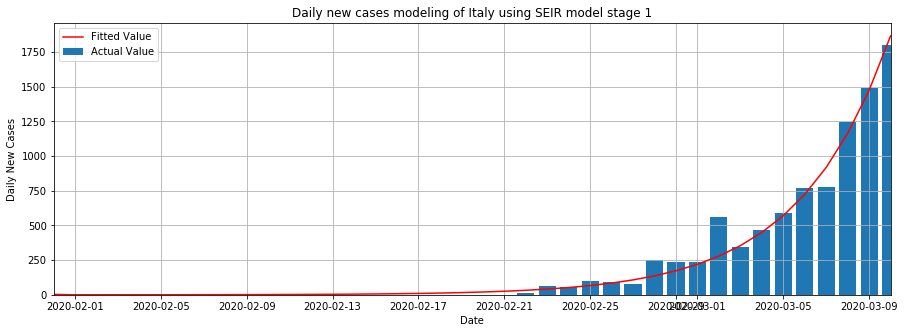

In [24]:
vis(1, date_interval1, prediction1, daily_new_cases1)

In [25]:
evaluate(daily_new_cases1, prediction1) #stage 1

0.981441558180763

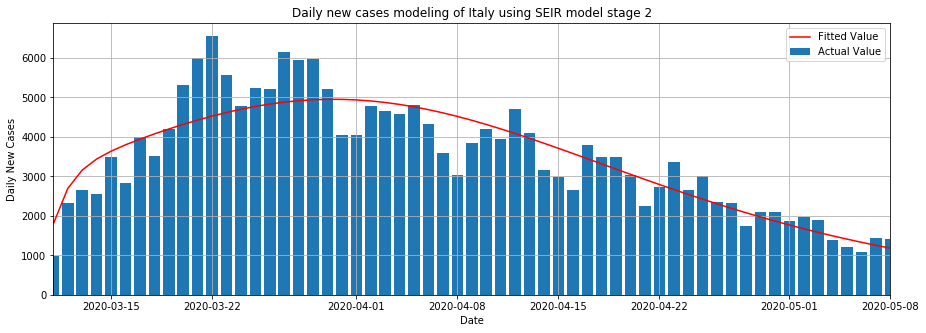

0.7850805127258669

In [26]:
# initial values stage 2
I0_2 = daily_new_cases1[-1]
S0_2 = 2.27258899e+05
E0_2 = I0_2 * 5
R0_2 = pop - I0_2 - S0_2 - E0_2

# solve SEIR
def solve_SEIR(t, beta, gamma):
    out2 = integrate.odeint(SEIR, [S0_2, E0_2, I0_2, R0_2], t, args=(beta, gamma))
    return out2[:, 2]

# fit SEIR
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval2, daily_new_cases2)


# generate date
start_date = country_data2.date.iloc[0]
days = len(t_interval2)
date_interval2 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction2 = solve_SEIR(t_interval2, *popt_seir)

# visualize
vis(2, date_interval2, prediction2, daily_new_cases2)

evaluate(daily_new_cases2, prediction2) # stage 2

In [27]:
# combine all stages
date_interval = np.concatenate((date_interval1, date_interval2))
prediction = np.concatenate((prediction1, prediction2))

In [28]:
# visualize
def vis_all(time, predict, actual):
    plt.figure(figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SEIR model ' + 'all stages')
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_seir_all.png')
    plt.show()

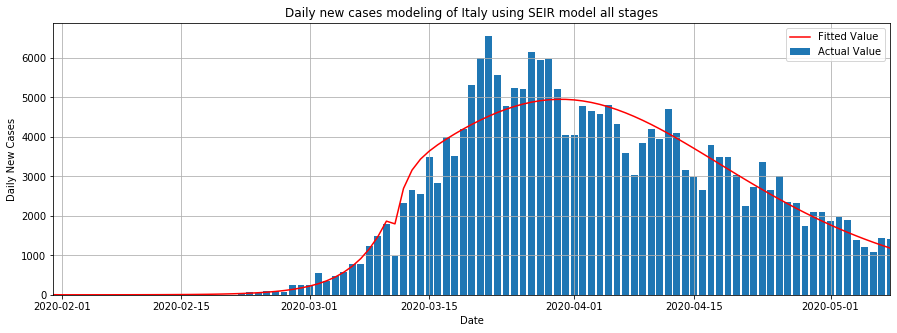

0.9324769023054134

In [29]:
vis_all(date_interval, prediction, country_data['new_cases'])
evaluate(country_data['new_cases'], prediction) # all stages

In [30]:
# compute ending time
predict_interval = np.arange(400)
predict_start_date = country_data2.date.iloc[0]
days = len(predict_interval)
predict_date_interval = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
predict_end = solve_SEIR(predict_interval, *popt_seir)
predict_end = predict_end.astype(int)
data = {'date': predict_date_interval, 'number': predict_end}
data = pd.DataFrame(data)
data[data['number']==0]

,date,number
164,2020-08-22,0
165,2020-08-23,0
166,2020-08-24,0
167,2020-08-25,0
168,2020-08-26,0
...,...,...
395,2021-04-10,0
396,2021-04-11,0
397,2021-04-12,0
398,2021-04-13,0
